# 1. Import Python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import exists
import PIL
import pathlib
import random
import seaborn

from evaluateCP import *

# Score function definition - standard setting

see https://arxiv.org/pdf/2306.09335.pdf 

In [2]:
def scorefunctionPS(model, x, y):
    
    rho_x = 1/2 - model.predict(x).squeeze()
    
    return y * rho_x + (1-y) * (-rho_x)

def scorefunctionCP(model, x, y):
    
    pred_prob_1 = model.predict(x).squeeze()
    pred_prob_0 = 1 - pred_prob_1
    
    return y * (1-pred_prob_1) + (1-y) * pred_prob_1

In [3]:
def getTNR(y_test,label,conformal_preds):
    tn=0
    
    for i, cp_instance in enumerate(conformal_preds):   
        if label in cp_instance and len(cp_instance)==1 and y_test[i]==label:
           # print(cp_instance)
            tn+=1
    y_test=np.array(y_test.squeeze())
    n = len(y_test[y_test == 0])
   # print("TN: ",tn)
   # print("n: ", n)
    return tn/n

# Compute Evaluation metrics - Probabilistic scaling

In [6]:
data_path = "data/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# common range of epsilon for testing
Epsilon = np.linspace(0.01, 0.5, 100)

for model_name in names:
    X_train = np.load(data_path + model_name +"_trainX.npy")
    Y_train = np.load(data_path + model_name +"_trainY.npy")
    X_test = np.load(data_path + model_name +"_testX.npy")
    Y_test = np.load(data_path + model_name +"_testY.npy")
    X_cal = np.load(data_path + model_name +"_calX.npy")
    Y_cal = np.load(data_path + model_name +"_calY.npy")

    model = keras.models.load_model(f"models/{model_name}.keras")
    n_c = len(Y_cal.squeeze())
    
    # compute scores for calibration points 
    s_Xcal = scorefunctionPS(model, X_cal, Y_cal)
     
    # compute test scores for both labels
    s_Xts1 = scorefunctionPS(model, X_test, 1)
    s_Xts0 = scorefunctionPS(model, X_test, 0)
    
    with open("metrics/newstandard_cp_Albi_"+model_name+".csv", "w") as ff:
        ff.write("epsilon,avgErr,stdErr,avgErr0,stdErr0,avgErr1,stdErr1,avgC,stdC,avgEmpty,stdEmpty,avgSingle,stdSingle,avgSingle0,stdSingle0,avgSingle1,stdSingle1,avgDouble,stdDouble,TNR\n")
    
    for eps in Epsilon:

        cpset_eps = getConformalSet(s_Xcal,s_Xts0,s_Xts1,eps,n_c)

        avgErr,stdErr, errSingleClass0, stderr0, errSingleClass1, stderr1, avgC, stdC, avgEmpty, stdEmpty, avgSingle,stdSingle, avgSingle0,stdSingle0, avgSingle1,stdSingle1,avgDouble,stdDouble = EvaluateConformal(cpset_eps,Y_test,0,1)
        
        tnr = getTNR(Y_test,0,cpset_eps)*100
        with open("metrics/newstandard_cp_Albi_"+model_name+".csv", "a") as ff:
            ff.write(str(eps)+","+str(avgErr)+','+str(stdErr)+','+str(errSingleClass0)+','+str(stderr0)+','+str(errSingleClass1)+','+str(stderr1)+','+str(avgC)+','+str(stdC)+','+str(avgEmpty)+","+str(stdEmpty)+','+str(avgSingle)+","+str(stdSingle)+","+str(avgSingle0)+","+str(stdSingle0)+","+str(avgSingle1)+","+str(stdSingle1)+','+str(avgDouble)+","+str(stdDouble)+","+str(tnr)+"\n")

108/108 [==============================] - 51s 476ms/step


# Compute evaluation metrics - standard CP

In [4]:

data_path = "data/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# common range of epsilon for testing
Epsilon = np.linspace(0.01, 0.5, 100)

for model_name in names:
    X_train = np.load(data_path + model_name +"_trainX.npy")
    Y_train = np.load(data_path + model_name +"_trainY.npy")
    X_test = np.load(data_path + model_name +"_testX.npy")
    Y_test = np.load(data_path + model_name +"_testY.npy")
    X_cal = np.load(data_path + model_name +"_calX.npy")
    Y_cal = np.load(data_path + model_name +"_calY.npy")

    model = keras.models.load_model(f"models/{model_name}.keras")
    n_c = len(Y_cal.squeeze())
    
    # compute scores for calibration points 
    s_Xcal = scorefunctionCP(model, X_cal, Y_cal)
     
    # compute test scores for both labels
    s_Xts1 = scorefunctionCP(model, X_test, 1)
    s_Xts0 = scorefunctionCP(model, X_test, 0)
    
    with open("metrics/newstandard_cp_"+model_name+".csv", "w") as ff:
        ff.write("epsilon,avgErr,stdErr,avgErr0,stdErr0,avgErr1,stdErr1,avgC,stdC,avgEmpty,stdEmpty,avgSingle,stdSingle,avgSingle0,stdSingle0,avgSingle1,stdSingle1,avgDouble,stdDouble,TNR\n")
    
    for eps in Epsilon:

        cpset_eps = getConformalSet(s_Xcal,s_Xts0,s_Xts1,eps,n_c)

        avgErr,stdErr, errSingleClass0, stderr0, errSingleClass1, stderr1, avgC, stdC, avgEmpty, stdEmpty, avgSingle,stdSingle, avgSingle0,stdSingle0, avgSingle1,stdSingle1,avgDouble,stdDouble = EvaluateConformal(cpset_eps,Y_test,0,1)
        
        tnr = getTNR(Y_test,0,cpset_eps)*100
        with open("metrics/newstandard_cp_"+model_name+".csv", "a") as ff:
            ff.write(str(eps)+","+str(avgErr)+','+str(stdErr)+','+str(errSingleClass0)+','+str(stderr0)+','+str(errSingleClass1)+','+str(stderr1)+','+str(avgC)+','+str(stdC)+','+str(avgEmpty)+","+str(stdEmpty)+','+str(avgSingle)+","+str(stdSingle)+","+str(avgSingle0)+","+str(stdSingle0)+","+str(avgSingle1)+","+str(stdSingle1)+','+str(avgDouble)+","+str(stdDouble)+","+str(tnr)+"\n")
    
    





108/108 [==============================] - 52s 477ms/step


# Plots 

# 1) average error - standard CP

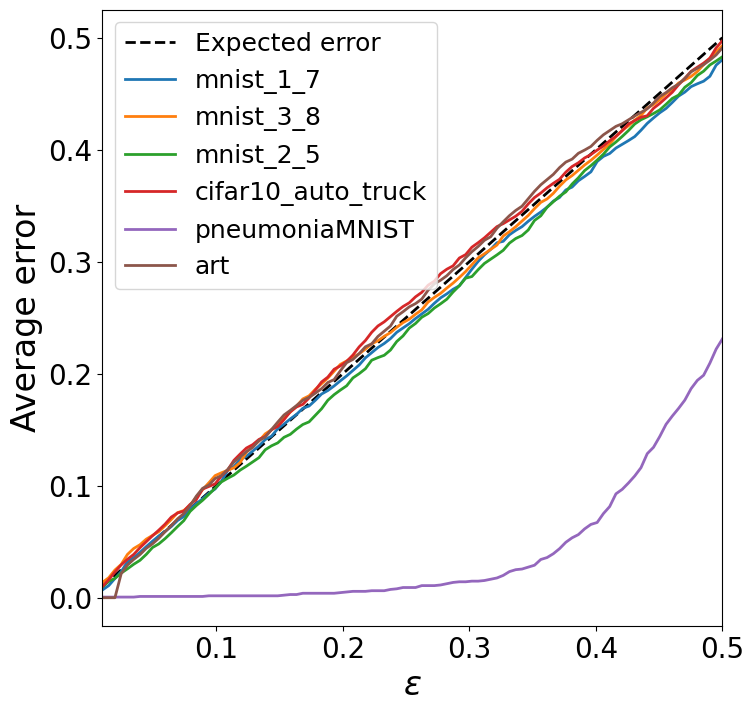

In [7]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgErr"].values
 
    if i == 0:
        plt.plot(epsrange,epsrange, color = "black", label = 'Expected error', linestyle='--', linewidth = 2)

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average error", fontsize = 24)
    
plt.show()   

# 2) average error- Probabilistic scaling

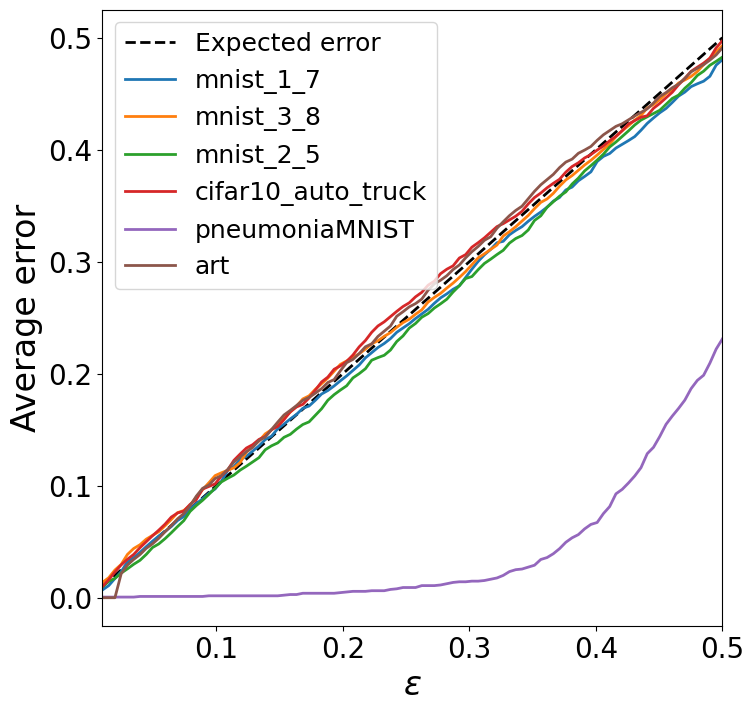

In [8]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_Albi_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgErr"].values    
   
    if i == 0:
        plt.plot(epsrange,epsrange, color = "black", label = 'Expected error', linestyle='--', linewidth = 2)

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average error", fontsize = 24)

plt.savefig("metrics/averageErr_AlbiCP.pdf", dpi = 200)
plt.show()   

# 3) average singleton - standard CP

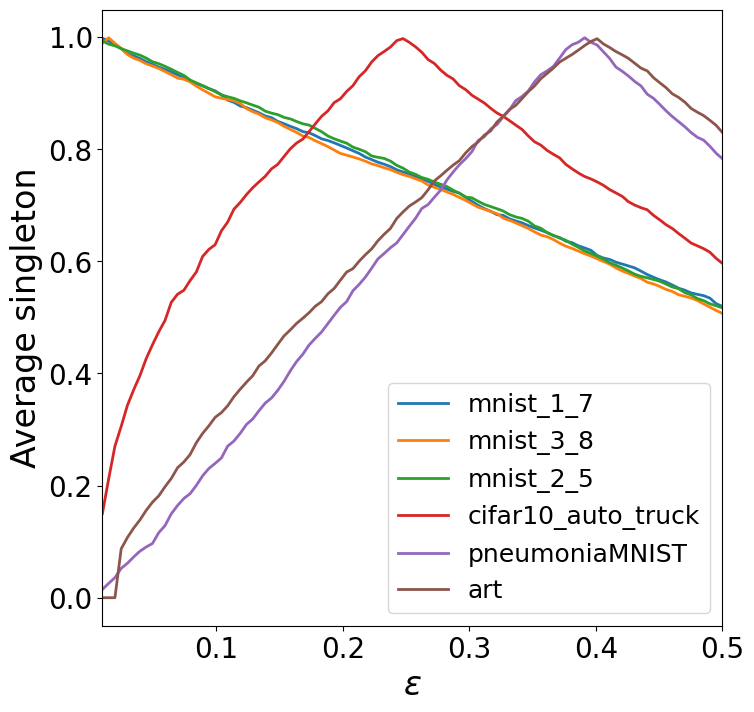

In [9]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgSingle"].values
   

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average singleton", fontsize = 24)
    

plt.show()   

# 4) average singleton - Probabilistic Scaling

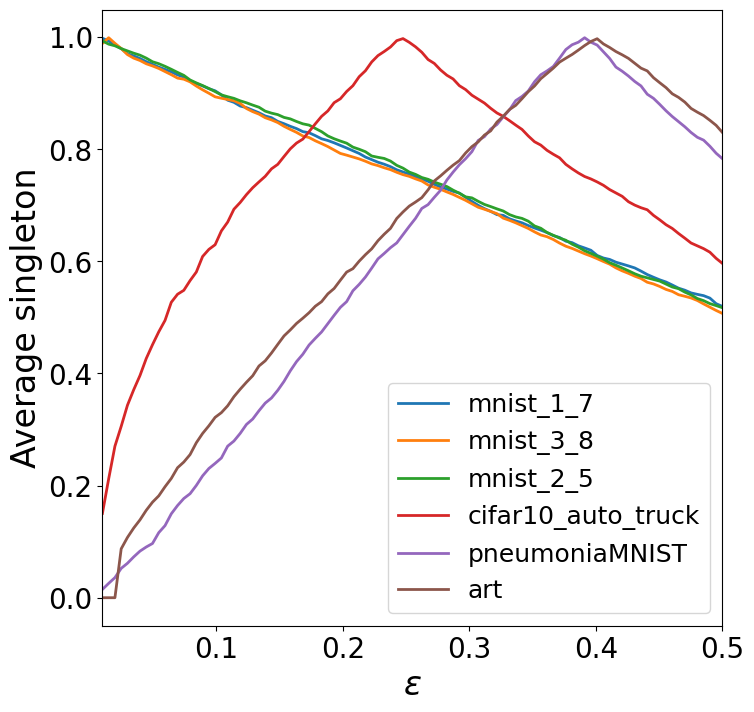

In [10]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_Albi_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgSingle"].values
    #FPR = data["FPR"].values
    

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average singleton", fontsize = 24)
    
    #TN = data["TN"].values
#plt.savefig("metrics/averageSingle_AlbiCP.pdf", dpi = 200)
plt.show()   

# 5) average empty - standard CP

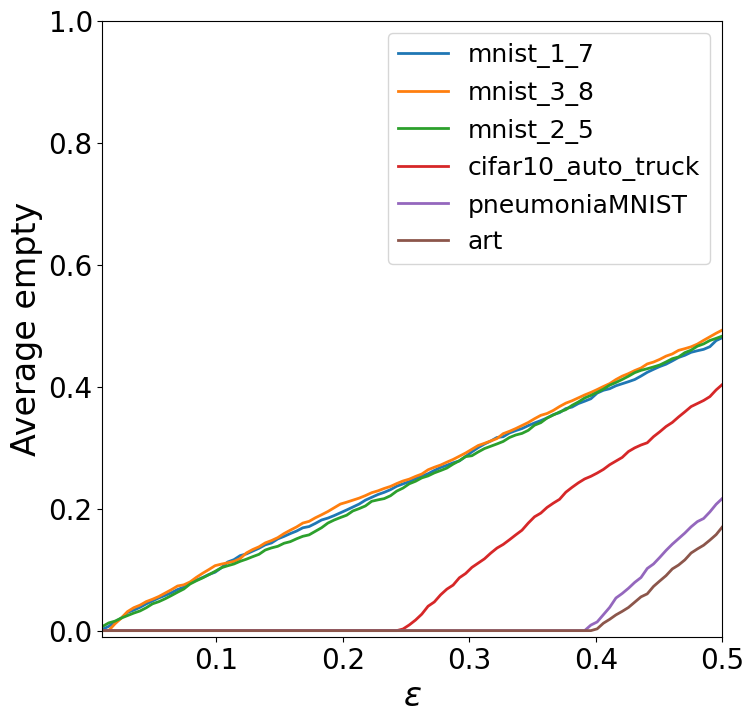

In [11]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgEmpty"].values
    #FPR = data["FPR"].values
    

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.ylim([-0.01,1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average empty", fontsize = 24)
    
    #TN = data["TN"].values
#plt.savefig("metrics/averageEmpty_standardCP.pdf", dpi = 200)
plt.show()   

# 6) average empty - Probabilistic Scaling

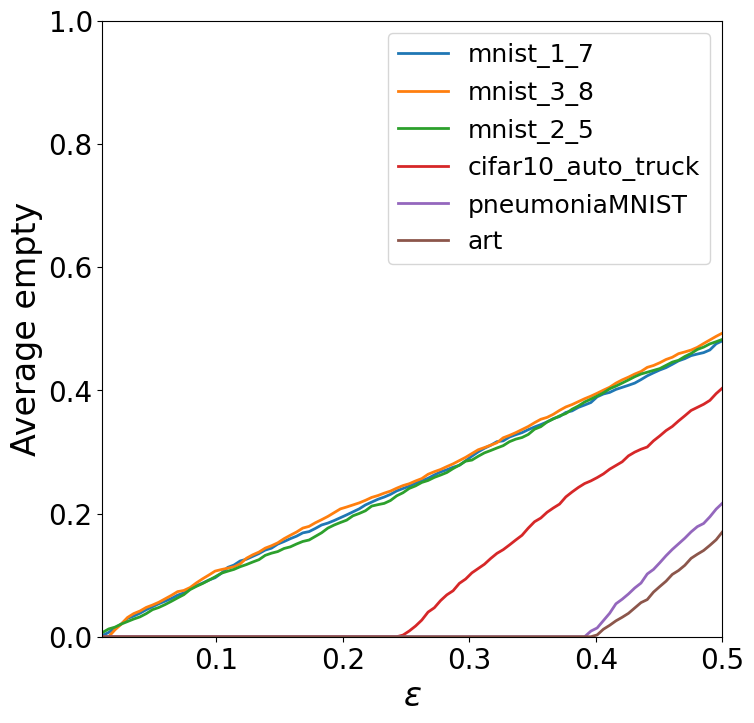

In [12]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_Albi_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgEmpty"].values
    #FPR = data["FPR"].values
    

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.ylim([0.0,1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average empty", fontsize = 24)
    
    #TN = data["TN"].values
#plt.savefig("metrics/averageEmpty_AlbiCP.pdf", dpi = 200)
plt.show()   

# 7) average double - standard CP

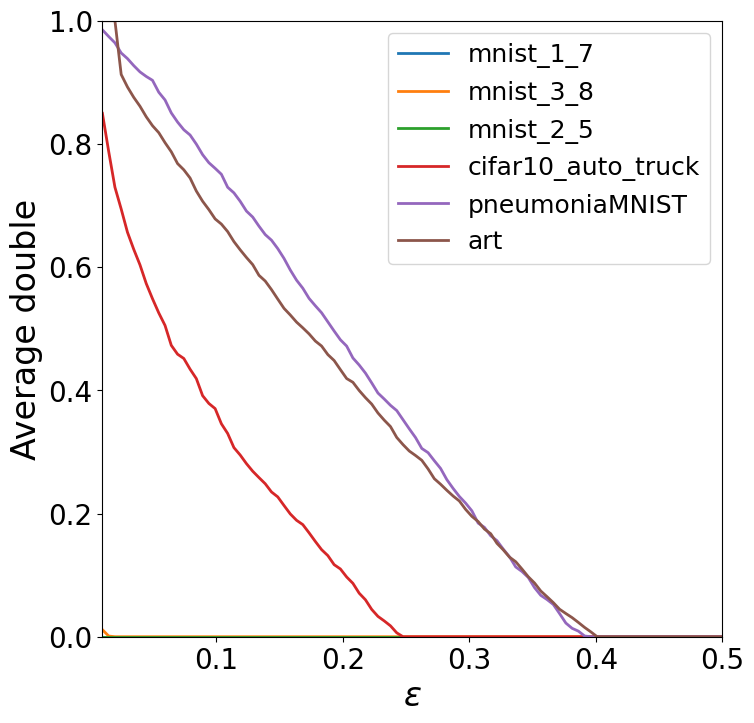

In [13]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgDouble"].values
    #FPR = data["FPR"].values
    

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.ylim([0.0,1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average double", fontsize = 24)
    
    #TN = data["TN"].values
#plt.savefig("metrics/averageDouble_standardCP.pdf", dpi = 200)
plt.show()   

# 8) average double - Probabilistic Scaling

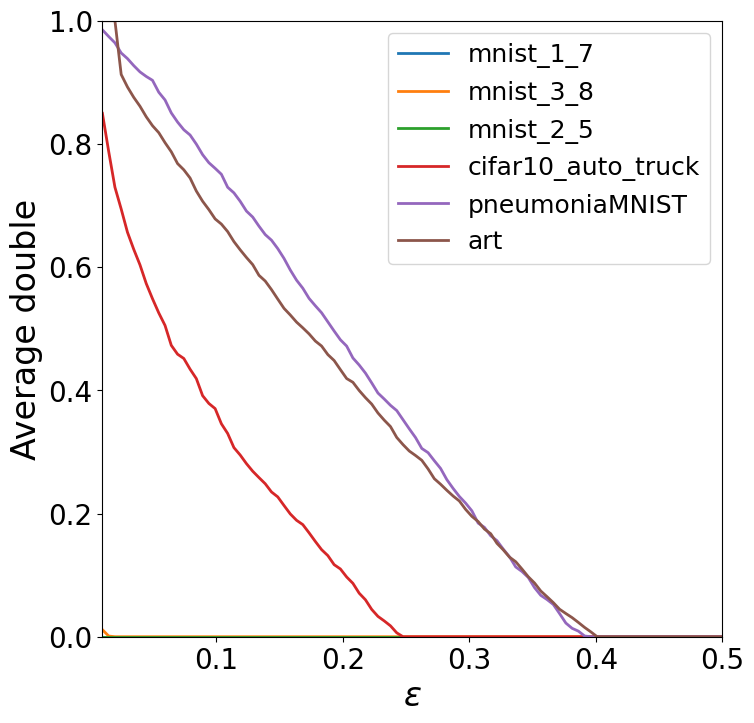

In [14]:
folder = "metrics/"
names = ["mnist_1_7", "mnist_3_8", "mnist_2_5", "cifar10_auto_truck","pneumoniaMNIST", "art"]
# fnr plot
for i, name in enumerate(names):
    data = pd.read_csv(folder+"newstandard_cp_Albi_"+name+".csv")
    
    if i == 0:
        plt.figure(figsize=(8, 8))
        plt.fontsize = 18
    
    epsrange = data["epsilon"].values
    FNR = data["avgDouble"].values
    #FPR = data["FPR"].values
    

    plt.plot(epsrange, FNR, label = name, linewidth = 2)
    plt.legend(fontsize = 18)
    plt.xlim([0.01,0.5])
    plt.ylim([0.0,1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("$\epsilon$", fontsize = 24)
    plt.ylabel("Average double", fontsize = 24)
    
    #TN = data["TN"].values
#plt.savefig("metrics/averageDouble_AlbiCP.pdf", dpi = 200)
plt.show()   